In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(10)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 100
num_epochs = 500
loss_fn = nn.BCELoss()

class CustomDataset(Dataset):
    def __init__(self, dataframe):
       self.dataframe = dataframe.apply(pd.to_numeric, errors='coerce')

    def __getitem__(self, index):
       row = self.dataframe.iloc[index].to_numpy()
       features = row[0:26]
       label = row[26]
       features_tensor = torch.tensor(features, dtype=torch.float32)
       label_tensor = torch.tensor(label, dtype=torch.float32)
       return features_tensor, label_tensor
    
    def __len__(self):
       return len(self.dataframe)
    
df = pd.read_csv('training data.csv')
df.set_index("PDB codes",inplace=True)
df = (df-df.min())/(df.max()-df.min())

train_df = df.iloc[1:556,0:27]
train = CustomDataset(dataframe=train_df)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)

val_df = df.iloc[1300:,0:27]
val = CustomDataset(dataframe=val_df)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(26, 50),
            nn.BatchNorm1d(num_features=50),
            nn.LeakyReLU(),
            #nn.Dropout(0.1),
            nn.Linear(50, 100),
            nn.BatchNorm1d(num_features=100),
            nn.LeakyReLU(),
            #nn.Dropout(0.1),
            nn.Linear(100, 50),
            nn.BatchNorm1d(num_features=50),
            nn.LeakyReLU(),
            #nn.Dropout(0.1),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)

Learning Rate 0.05: 0.84 training accuracy and 0.71 validation accuracy
Learning Rate 0.025: 0.86 training accuracy and 0.72 validation accuracy
Learning Rate 0.0125: 0.87 training accuracy and 0.73 validation accuracy
Learning Rate 0.00625: 0.88 training accuracy and 0.73 validation accuracy
Learning Rate 0.003125: 0.87 training accuracy and 0.73 validation accuracy
Learning Rate 0.0015625: 0.85 training accuracy and 0.71 validation accuracy


KeyboardInterrupt: 

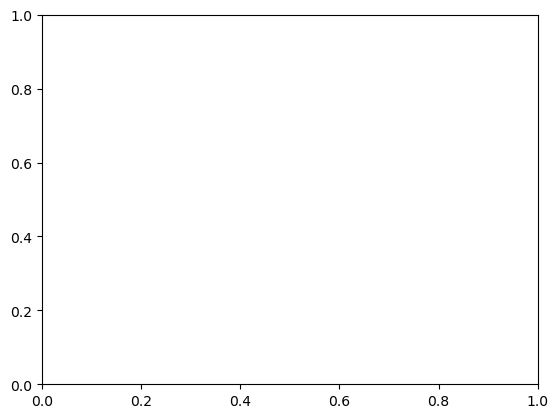

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = 0
    for true,pred in zip(y_true,y_pred):
        if true.item()==pred.item():
            correct+=1
    return correct/len(y_true)

def train(model, num_epochs, loss_fn, train_data, optimizer, test_data=None):

    train_acc = []
    #train_losses = []

    val_acc = []
    #val_losses = []

    #epoch_loss1 = []
    epoch_acc1 = []

    #epoch_loss2 = []
    epoch_acc2 = []

    for epoch in range(num_epochs):
        neural_net.train()
        for i, data in enumerate(train_loader):
            values, labels = data
            values = values.to(torch.float32)
            labels = labels.to(torch.float32)

            optimizer.zero_grad()

            train_preds = neural_net(values)
            train_preds = train_preds.squeeze(dim=1)

            train_loss = loss_fn(train_preds, labels)
            #epoch_loss1.append(train_loss.item())
        
            epoch_acc1.append(accuracy_fn(labels, torch.round(train_preds)))

            train_loss.backward()
            optimizer.step()
        train_acc.append(np.mean(epoch_acc1))
        #train_losses.append(np.mean(epoch_loss1))
        
        neural_net.eval()
        for j, data in enumerate(test_data):
            values, labels = data
            values = values.to(torch.float32)
            labels = labels.to(torch.float32)
            
            val_preds = neural_net(values).squeeze(dim=1)
            
            val_loss = loss_fn(val_preds, labels)
            #epoch_loss2.append(val_loss.item())

            epoch_acc2.append(accuracy_fn(labels, torch.round(val_preds)))
        val_acc.append(np.mean(epoch_acc2))
        #val_losses.append(np.mean(epoch_loss2))

    return np.mean(train_acc), np.mean(val_acc)

lrs = []
start = 0.1
for i in range(10):
    start*=0.5
    lrs.append(start)

all_train_accuracies = []
all_val_accuracies = []
fig, ax = plt.subplots()

for i, lr in enumerate(lrs):
    neural_net = NeuralNet()
    neural_net.apply(init_weights)
    optimizer = torch.optim.Adam(neural_net.parameters(), lr=lr)
    train_acc, val_acc = train(neural_net, num_epochs, loss_fn, train_loader, optimizer, test_data=val_loader)
    all_train_accuracies.append(train_acc)
    all_val_accuracies.append(val_acc)
    print(f'Learning Rate {lr}: {train_acc:.2f} training accuracy and {val_acc:.2f} validation accuracy')

plt.plot(lrs, all_train_accuracies, label='Training Accuracy')
plt.plot(lrs, all_val_accuracies, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
